In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import PIL as Image

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, SpatialDropout2D, BatchNormalization, Flatten, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
labels = os.listdir('/content/drive/My Drive/Surface Detection 3500')
print(labels)

['Negative', 'Positive']


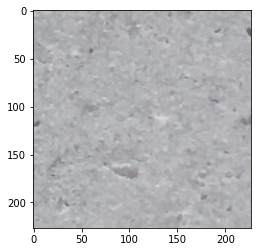

In [25]:
DATADIR = '/content/drive/My Drive/Surface Detection 3500'
CATEGORIES = ['Negative', 'Positive']

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
    plt.imshow(img_array)
    break
  break


In [26]:
img_array.shape

(227, 227, 3)

Resizing all the images to 128x128 pixels and creation of train_data.

In [27]:
train_data = []

def make_train_data():

  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:

        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img_array, (128,128))
        train_data.append([img_resized, class_num])

      except Exception as e:
        pass

make_train_data()

In [28]:
print(len(train_data))

7000


In [29]:
import random
random.shuffle(train_data)

In [30]:
for sample in train_data[:5]:           # to check the labels
    print(sample[1])

0
0
1
1
0


In [31]:
X = []        # for features
Y = []        # for labels   

In [32]:
for features, labels in train_data:
  X.append(features)
  Y.append(labels)

X = np.array(X).reshape(-1,128,128, 3)

In [33]:
X.shape

(7000, 128, 128, 3)

In [34]:
Y = keras.utils.to_categorical(Y, num_classes = 2)
y = np.array(Y)

In [35]:
y

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [36]:
y.shape

(7000, 2)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [38]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4900, 128, 128, 3), (2100, 128, 128, 3), (4900, 2), (2100, 2))

Keras model.

In [39]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'same',activation = 'relu', input_shape = (128,128,3), name = 'Conv2D_1'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3,3)))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = 'same',activation = 'relu', name = 'Conv2D_2'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3,3)))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(filters = 96, kernel_size = (5,5), padding = 'same', activation = 'relu', name = 'Conv2D_3'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3,3)))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(filters = 128, kernel_size = (5,5), padding = 'same', activation = 'relu', name = 'Conv2D_4'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3,3)))
model.add(SpatialDropout2D(0.2))

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.15))

model.add(Dense(2, activation = 'softmax'))

model.compile(loss = keras.losses.CategoricalCrossentropy(),
             optimizer = keras.optimizers.RMSprop(learning_rate = 0.001),
              metrics = [keras.metrics.CategoricalAccuracy()])

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 42, 42, 32)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 42, 42, 64)        51264     
_________________________________________________________________
batch_normalization_6 (Batch (None, 42, 42, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)       

Data augmentation step

In [41]:
datagen = ImageDataGenerator(
    
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range= 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True    # randomly flip images
) 

datagen.fit(X_train)

Fitting of the model.

In [43]:
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 128),
                                    epochs = 5, validation_data = (X_test, y_test),
                                    verbose = 1, steps_per_epoch=X_train.shape[0] // 128)

Epoch 1/5
38/38 [==============================] - 262s 7s/step - loss: 0.0498 - categorical_accuracy: 0.9832 - val_loss: 0.8896 - val_categorical_accuracy: 0.5405
Epoch 2/5
38/38 [==============================] - 261s 7s/step - loss: 0.0529 - categorical_accuracy: 0.9813 - val_loss: 0.0570 - val_categorical_accuracy: 0.9895
Epoch 3/5
38/38 [==============================] - 263s 7s/step - loss: 0.0447 - categorical_accuracy: 0.9858 - val_loss: 0.1456 - val_categorical_accuracy: 0.9548
Epoch 4/5
38/38 [==============================] - 262s 7s/step - loss: 0.0356 - categorical_accuracy: 0.9881 - val_loss: 0.0861 - val_categorical_accuracy: 0.9719
Epoch 5/5
38/38 [==============================] - 264s 7s/step - loss: 0.0309 - categorical_accuracy: 0.9887 - val_loss: 0.0245 - val_categorical_accuracy: 0.9938


Model evaluation.

In [44]:
model_eval = model.evaluate(X_test, y_test)

print("Loss = ", model_eval[0])
print("Test accuracy = ", model_eval[1]*100)

2100/2100 [==============================] - 30s 14ms/step
Loss =  0.024455260258345376
Test accuracy =  99.38095211982727


To see whether the loss and accuracy are conserved or not.

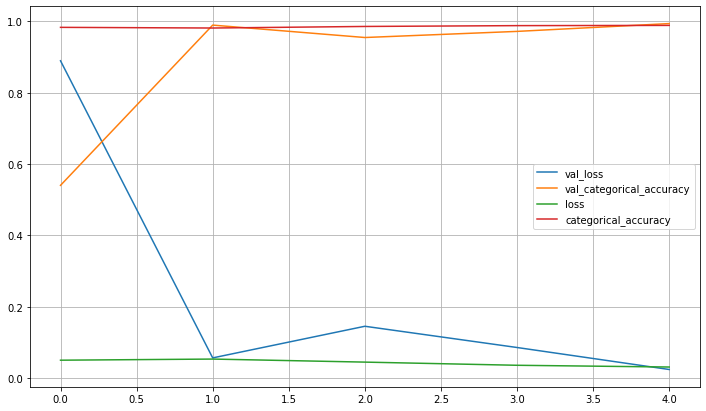

In [45]:
pd.DataFrame(model_history.history).plot(figsize = (12,7))
plt.gca()
plt.grid(True)
plt.show()

Prediction on X_test

In [46]:
y_predict = model.predict_classes(X_test)
y_predict

array([0, 1, 0, ..., 0, 1, 0])

Return the max value in the array.

In [47]:
y_test = y_test.argmax(1)
y_test

array([0, 1, 0, ..., 0, 1, 0])

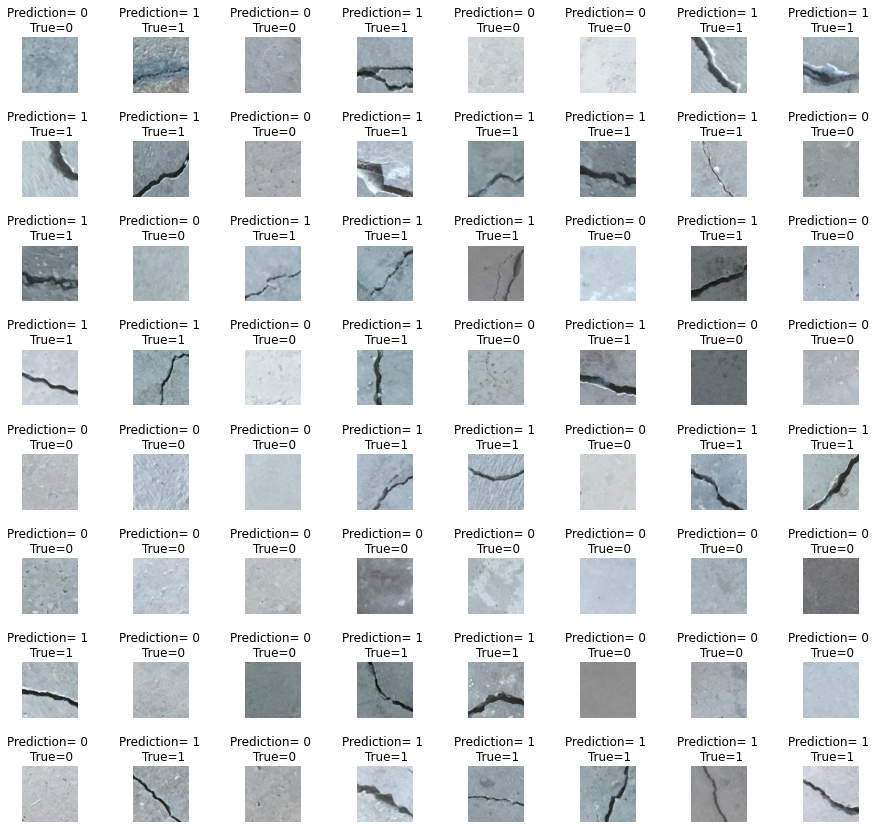

In [48]:
L = 8                                                                            # 0 stands for Negative i.e, no crack
W = 8                                                                            # 1 stands for Positive i.e, there is crack
fig,axes = plt.subplots(L,W,figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction= {} \n True={}'.format(y_predict[i], y_test[i]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)